# Sentiment analysis using logistic Regression

kaggle data-link -> https://www.kaggle.com/datasets/kazanova/sentiment140/data

# Sentiment Analysis: Overview and Techniques

Sentiment analysis, also known as opinion mining, is the process of computationally identifying and categorizing opinions expressed in text data to determine the sentiment conveyed by the text. It's a valuable technique used in various applications such as social media monitoring, customer feedback analysis, and market research.

## Overview:
- **Objective**: Analyze and classify the sentiment expressed in text data as positive, negative, or neutral.
- **Techniques**: Sentiment analysis can be performed using various techniques, including rule-based methods, machine learning algorithms, and deep learning models.
- **Applications**: Used in social media monitoring, customer feedback analysis, brand reputation management, and market research to understand public opinion and sentiment trends.

## Techniques:
1. **Rule-Based Methods**: These methods rely on predefined rules or lexicons to determine the sentiment of text data. Lexicon-based approaches assign sentiment scores to words or phrases and aggregate them to determine the overall sentiment of a piece of text.

2. **Machine Learning**: Machine learning algorithms such as Naive Bayes, Support Vector Machines (SVM), and Random Forests can be trained on labeled datasets to classify text data into positive, negative, or neutral sentiments. Features can include word frequencies, n-grams, or word embeddings.

3. **Deep Learning**: Deep learning models, particularly Recurrent Neural Networks (RNNs), Long Short-Term Memory (LSTM) networks, and Convolutional Neural Networks (CNNs), can learn complex patterns in text data and automatically extract features for sentiment classification.

## Evaluation Metrics:
- **Accuracy**: The percentage of correctly classified instances.
- **Precision and Recall**: Metrics to evaluate the performance of the classifier, especially in the context of imbalanced datasets.
- **F1 Score**: The harmonic mean of precision and recall, providing a balanced measure of the classifier's performance.
- **Confusion Matrix**: A table used to evaluate the performance of a classification model, displaying the counts of true positive, false positive, true negative, and false negative predictions.

## Implementation:
- Sentiment analysis can be implemented using various libraries and frameworks, including NLTK (Natural Language Toolkit), scikit-learn, TensorFlow, and PyTorch.
- Pretrained models and libraries such as VADER (Valence Aware Dictionary and sEntiment Reasoner) provide off-the-shelf solutions for sentiment analysis tasks.

## Challenges:
- **Context Understanding**: Understanding the context, sarcasm, and nuances of language can be challenging for sentiment analysis models.
- **Domain Specificity**: Sentiment analysis models may perform differently across different domains and industries due to domain-specific language and vocabulary.

# LSTM

In [157]:
import numpy as np
import pandas as pd
import re

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
# from nltk.stem.porter import SnowballStemmer
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /home/chaos/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## data processing

In [158]:
twitter_data = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding='ISO-8859-1')
print(twitter_data.shape)
twitter_data.head()

(1599999, 6)


,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [159]:
column_names = ['target', 'id', 'date', 'flag', 'user', 'text']
twitter_data = pd.read_csv('training.1600000.processed.noemoticon.csv', names=column_names, encoding='ISO-8859-1')
twitter_data.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [130]:
twitter_data.isnull().sum()

target    0
id        0
date      0
flag      0
user      0
text      0
dtype: int64

In [131]:
twitter_data = twitter_data.drop(['id', 'date', 'flag', 'user'], axis=1)
twitter_data.tail()

,target,text
1599995,4,Just woke up. Having no school is the best fee...
1599996,4,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,Happy 38th Birthday to my boo of alll time!!! ...
1599999,4,happy #charitytuesday @theNSPCC @SparksCharity...


In [132]:
#checking the distribution: 
twitter_data['target'].value_counts()

target
0    800000
4    800000
Name: count, dtype: int64

In [135]:
twitter_data.replace({'target':{4:1}}, inplace=True)

twitter_data['target'].value_counts()

target
0    800000
1    800000
Name: count, dtype: int64

Text(0.5, 1.0, 'the data distribution: ')

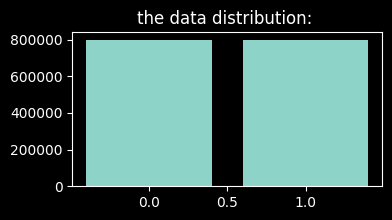

In [136]:
val_count = twitter_data.target.value_counts()
plt.figure(figsize=(4, 2))
plt.bar(val_count.index, val_count.values)
plt.title("the data distribution: ")

## text preprocessing :

In [137]:
# Initialize Porter Stemmer
port_stem = PorterStemmer()

In [138]:
def stemming(content):
    # Remove non-alphabetic characters and convert to lowercase
    stemmed_content = re.sub('[^a-zA-Z]', ' ', content)
    stemmed_content = stemmed_content.lower()
    
    # Tokenize the text
    stemmed_content = stemmed_content.split()
    
    # Apply stemming and remove stopwords
    stemmed_content = [port_stem.stem(word) for word in stemmed_content if word not in stopwords.words('english')]
    
    # Join the stemmed words back into a string
    stemmed_content = ' '.join(stemmed_content)

    return stemmed_content

In [139]:
twitter_data['stemmed_content'] = twitter_data['text'].apply(stemming)  #approx 16min

In [140]:
df = twitter_data

In [141]:
twitter_data.head()

,target,text,stemmed_content
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",switchfoot http twitpic com zl awww bummer sho...
1,0,is upset that he can't update his Facebook by ...,upset updat facebook text might cri result sch...
2,0,@Kenichan I dived many times for the ball. Man...,kenichan dive mani time ball manag save rest g...
3,0,my whole body feels itchy and like its on fire,whole bodi feel itchi like fire
4,0,"@nationwideclass no, it's not behaving at all....",nationwideclass behav mad see


In [142]:
print(twitter_data['target'])

0          0
1          0
2          0
3          0
4          0
          ..
1599995    1
1599996    1
1599997    1
1599998    1
1599999    1
Name: target, Length: 1600000, dtype: int64


## save the df, as csv for saving the time

In [143]:
twitter_data.to_csv('stemmed_twitter_data_nn.csv', index=False)

In [144]:
# twitter_data = pd.read_csv('stemmed_twitter_data_nn.csv')
# twitter_data.head()

In [156]:
from wordcloud import WordCloud

plt.figure(figsize=(10, 10))  
wc = WordCloud(max_words=2000, width=1600, height=800).generate(" ".join(twitter_data[twitter_data.target == 'Positive'].text))
plt.imshow(wc, interpolation='bilinear')
plt.show()  


ValueError: We need at least 1 word to plot a word cloud, got 0.

<Figure size 1000x1000 with 0 Axes>

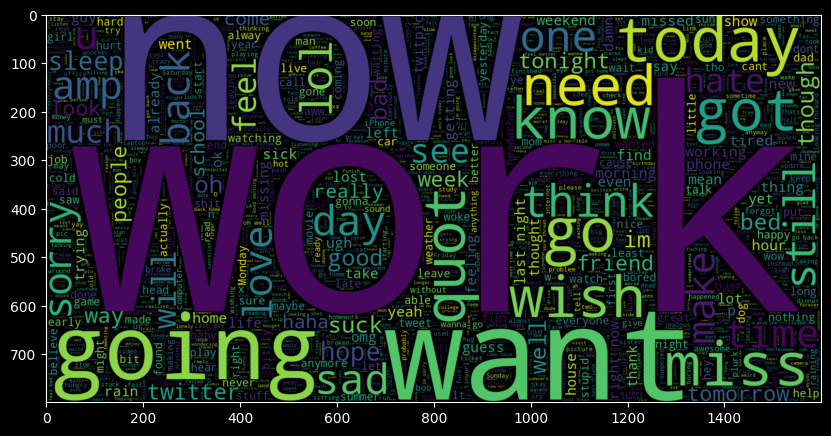

In [ ]:
plt.figure(figsize=(10, 10))  
wc = WordCloud(max_words=2000, width=1600, height=800).generate(" ".join(twitter_data[twitter_data.target == 'Negative'].text))
plt.imshow(wc, interpolation='bilinear')
plt.show()  

## separating data and the target

In [145]:
twitter_data.head()

,target,text,stemmed_content
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",switchfoot http twitpic com zl awww bummer sho...
1,0,is upset that he can't update his Facebook by ...,upset updat facebook text might cri result sch...
2,0,@Kenichan I dived many times for the ball. Man...,kenichan dive mani time ball manag save rest g...
3,0,my whole body feels itchy and like its on fire,whole bodi feel itchi like fire
4,0,"@nationwideclass no, it's not behaving at all....",nationwideclass behav mad see


In [146]:
from sklearn.model_selection import train_test_split

#seperate the features and the target
X = twitter_data['stemmed_content']
Y = twitter_data['target']

In [147]:
# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


In [148]:
# Display the shapes of the resulting sets
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of Y_train:", Y_train.shape)
print("Shape of Y_test:", Y_test.shape)

Shape of X_train: (1280000,)
Shape of X_test: (320000,)
Shape of Y_train: (1280000,)
Shape of Y_test: (320000,)


## the model

#### 1. Import the necessary libraries.
#### 2. Load and preprocess the data.
#### 3. Tokenize the text data and convert it into sequences of integers.
#### 4. Pad or truncate the sequences to ensure uniform length.
#### 5. Define the LSTM model architecture.
#### 6. Compile the model with an appropriate loss function and optimizer.
#### 7. Train the model on the training data.
#### 8. Evaluate the model on the testing data.
#### 9. Optionally, fine-tune the model parameters.
#### 10. Save the trained model for future use.

In [149]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense


In [150]:
# 3. Tokenize the text data and convert it into sequences of integers.

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train_tokenized = tokenizer.texts_to_sequences(X_train)
X_test_tokenized = tokenizer.texts_to_sequences(X_test)

In [151]:
# 4. Pad or truncate the sequences to ensure uniform length.

max_sequence_length = 100  
X_train_padded = pad_sequences(X_train_tokenized, maxlen=max_sequence_length, padding='post')
X_test_padded = pad_sequences(X_test_tokenized, maxlen=max_sequence_length, padding='post')


In [152]:
vocab_size = len(tokenizer.word_index) + 1  
embedding_dim = 100

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    LSTM(units=128),
    Dense(units=1, activation='sigmoid')
])


In [153]:
# 6. Compile the model with an appropriate loss function and optimizer.

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

## The target variable is in string format ('Positive' and 'Negative'), but the model requires numerical labels for binary classification ('0' and '1').

In [154]:
# 7. Train the model on the training data.

history = model.fit(X_train_padded, Y_train, batch_size=64, epochs=5, validation_data=(X_test_padded, Y_test))

Epoch 1/5
 3477/20000 ━━━━━━━━━━━━━━━━━━━━ 1:14:27 270ms/step - accuracy: 0.5011 - loss: 0.6932

Exception ignored in: <function SeekableUnicodeStreamReader.__del__ at 0x72ea50bc4220>
Traceback (most recent call last):
  File "/mnt/coding/oll/lib/python3.11/site-packages/nltk/data.py", line 1160, in __del__
    if not self.closed:
           ^^^^^^^^^^^
  File "/mnt/coding/oll/lib/python3.11/site-packages/nltk/data.py", line 1180, in closed
    return self.stream.closed
           ^^^^^^^^^^^
AttributeError: 'SeekableUnicodeStreamReader' object has no attribute 'stream'


KeyboardInterrupt: 

In [ ]:
# 8. Evaluate the model on the testing data.

loss, accuracy = model.evaluate(X_test_padded, Y_test)
print("Test Accuracy:", accuracy)
